# Colab專屬

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pytorch Docker專屬

In [ ]:
# !pip install pandas numpy scikit-learn matplotlib

# 必須的套件引入

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

# 分類任務(刷模型)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import datetime

# Get the current time
current_time = datetime.datetime.now()

# Format the time
formatted_time = current_time.strftime("%Y_%m_%d_%H_%M_%S")

print("Current time:", formatted_time)

# Read the data
data = pd.read_csv('/content/drive/MyDrive/LSTM/input/stock_train/2330_2010_to_202405.csv')

# Select the necessary features and target variable
features = data[['Open', 'High', 'Low', 'Close', 'Volume']]
target = data['Change']

# Modify the target values
def transform_target(value):
    if value < 0:
        return [1, 0, 0]  # Negative change
    elif value == 0:
        return [0, 1, 0]  # No change
    else:
        return [0, 0, 1]  # Positive change

# Modify the target data into categorical data (originally [0,0,0])
new_target = []
for value in target:
    new_target.append(transform_target(value))

# Convert date to numeric (if needed)
data['Date'] = pd.to_datetime(data['Date'])
data['Date'] = data['Date'].map(pd.Timestamp.timestamp)

# Normalize the data
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
print("scaled_features : ",scaled_features[0])

# Split the data into training and testing sets, 90% training, 10% testing
train_size = int(len(scaled_features) * 0.9)
test_size = len(scaled_features) - train_size

train_features = scaled_features[:train_size]
train_target = new_target[:train_size]
test_features = scaled_features[train_size:]
test_target = new_target[train_size:]
print("train_features : ",train_features[0])

# Create input format for LSTM
def create_sequences(features, target, time_step=1):
    X, y = [], []
    for i in range(len(features) - time_step):
        X.append(features[i:(i + time_step), :])
        y.append(target[i + time_step])
    return np.array(X), np.array(y)

# Time step for LSTM
time_step = 10

# Create training and testing data
X_train, y_train = create_sequences(train_features, train_target, time_step)
X_test, y_test = create_sequences(test_features, test_target, time_step)

# Check if CUDA is available
USE_CUDA = torch.cuda.is_available()

# Set device to cuda:0 if GPU is available, otherwise use CPU
device = torch.device('cuda:0' if USE_CUDA else 'cpu')
print("****CUDA Status****")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CUDA Device: {torch.cuda.current_device()}")
print(f"CUDA Device Name: {torch.cuda.get_device_name(device)}")
#print(X_train[0])

# Convert training feature data to PyTorch tensor, specifying the data type as float32, then move it to the specified device (GPU or CPU)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)

# Convert training target data to PyTorch tensor, specifying the data type as float32, and reshape, then move it to the specified device (GPU or CPU)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

# Convert testing feature data to PyTorch tensor, specifying the data type as float32, then move it to the specified device (GPU or CPU)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Convert testing target data to PyTorch tensor, specifying the data type as float32, and reshape, then move it to the specified device (GPU or CPU)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)
print("****Data Status****")
print(f"Training data: {len(X_train_tensor)} records")
print(f"Testing data: {len(X_test_tensor)} records")

import pickle

# Save scaler object
with open('/content/drive/MyDrive/LSTM/input/stock_train/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    print("Scaler saved")


# Define a class named LSTM, inheriting from nn.Module
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        # Call the constructor of the parent class nn.Module
        super(LSTM, self).__init__()
        # Set the hidden layer dimension of the LSTM model
        self.hidden_dim = hidden_dim
        # Set the number of layers of the LSTM model
        self.num_layers = num_layers
        # Create the LSTM layer, specifying the input dimension, hidden layer dimension, number of layers, and batch-first setting
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        # Create a fully connected layer to map the hidden layer output to the output dimension
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize the hidden and cell states of the LSTM to zeros and move them to the specified device
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        # Move the input data to the specified device and pass it to the LSTM layer, getting the output and new hidden and cell states
        out, (hn, cn) = self.lstm(x.to(device), (h0.detach(), c0.detach()))
        # Pass the LSTM output to the fully connected layer, using only the output of the last time step
        out = self.fc(out[:, -1, :])
        # Move the final output to the specified device and return
        return out.to(device)

# Set hyperparameters
# Get the dimension of the input data
input_dim = X_train.shape[2]
print("X_train.shape[2] : ",X_train.shape[2])
# Set the hidden layer dimension of the LSTM model
hidden_dim = 200
# Set the number of layers of the LSTM model
num_layers = 2
# Set the output dimension of the model
output_dim = 3
# Set the dropout layer for LSTM stacking
dropout = 0.001

# Initialize the learning rate
initial_lr = 0.005
# Set the batch size
batch_size = 32
# Calculate the scaling factor based on the ratio of the new batch size to the original batch size
scale_factor = batch_size / 64 # Original batch size is 64
# Adjust the learning rate to grow proportionally with the new batch size
lr = initial_lr * scale_factor
# Define the loss function and optimizer
#criterion = nn.SmoothL1Loss()
criterion = nn.CrossEntropyLoss() # more better
#criterion = nn.BCEWithLogitsLoss()


# Function to compute accuracy
def compute_accuracy(outputs, targets):
    predicted_D = outputs.detach().cpu().numpy()
    actual_D = targets.cpu().numpy()
    # Convert predicted values and actual values to labels
    predicted_labels_D = map_to_label(predicted_D)
    actual_labels_D = map_to_label(actual_D)
    accuracy_D = accuracy_score(actual_labels_D, predicted_labels_D)
    return accuracy_D
# Convert predicted values to labels
def map_to_label(array):
    labels = []
    for row in array:
        max_index = np.argmax(row)
        if max_index == 0:
            labels.append(-1)
        elif max_index == 1:
            labels.append(0)
        elif max_index == 2:
            labels.append(1)
    return labels

# Record the number of model training times
training_times = 0
model_save = 0
high_acc = 49.55
while(True):
    # Create LSTM model and move it to GPU
    model = LSTM(input_dim, hidden_dim, num_layers, output_dim, dropout).to(device)
    # Set the total number of epochs for training
    num_epochs = 200
    # Set the initial value of the best validation loss to infinity
    best_valid_loss = float('inf')
    # Set the early stopping threshold (if the validation loss does not improve for 10 consecutive epochs, stop training)
    early_stop_threshold = int(num_epochs / 1)
    # Initialize the counter for consecutive epochs without improvement
    no_improvement_count = 0
    total_valid_accuracy = 0
    # Optimizer settings
    optimizer = optim.AdamW(model.parameters(), lr=lr) # more better
    # optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    # optimizer = optim.Adagrad(model.parameters(), lr=lr)
    # Define the learning rate scheduler, reducing the learning rate to 0.95 of the original every ten epochs
    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)

    training_times += 1
    print(f"第{training_times}次模型訓練")
    # Train LSTM model
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        start_time = time.time()  # Record the start time of the current epoch
        total_loss = 0
        total_correct = 0
        total_samples = 0
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]  # Extract a batch of feature data from the training set
            batch_y = y_train_tensor[i:i+batch_size]  # Extract a batch of target data from the training set
            # Get the model's predictions
            outputs = model(batch_X)
            # Calculate the model's loss
            loss = criterion(outputs, batch_y)
            # Backpropagation of gradients and parameter updates
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss = total_loss + loss.item()
            # Calculate accuracy within the batch
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == batch_y.argmax(dim=1)).sum().item()
            total_samples += batch_y.size(0)
        # Calculate accuracy for the entire epoch
        train_accuracy = total_correct / total_samples
        if(epoch>=int(num_epochs/2)):
            # Evaluate the model on the validation set after each epoch
            model.eval()  # Set the model to evaluation mode
            valid_loss = 0
            with torch.no_grad():
                for i in range(0, len(X_test_tensor), batch_size):
                    batch_X_valid = X_test_tensor[i:i+batch_size]
                    batch_y_valid = y_test_tensor[i:i+batch_size]
                    valid_outputs = model(batch_X_valid)
                    valid_loss += criterion(valid_outputs, batch_y_valid).item()
            valid_loss /= len(X_test_tensor) / batch_size
            # If the loss on the validation set is smaller than the best loss, update the best loss and reset the counter for epochs without improvement
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            # If the counter for epochs without improvement reaches the threshold for early stopping, stop training
            if no_improvement_count >= early_stop_threshold:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
        scheduler.step()  # Adjust the learning rate after each epoch (counting)
        model.eval()  # Set the model to evaluation mode

        if epoch % 20 == 0:
            elapsed = time.time() - start_time  # Calculate the execution time of the current epoch
            # Print some information during the training process, such as the current epoch number, learning rate, execution time, loss, and accuracy
            print('| epoch {:4d} | lr {:02.10f} | {:5.2f} ms | loss {:5.7f} | train accuracy {:3.2f}%'.format(
                epoch+20,scheduler.get_last_lr()[0], elapsed * 1000, total_loss, train_accuracy*100))
    # Set the model to evaluation mode, disabling certain specific operations during training, such as random deactivation in Dropout and Batch Normalization
    model.eval()
    # Make predictions using the test dataset
    test_outputs = model(X_test_tensor)  # Get the model's predictions for the test dataset features
    # Calculate the loss on the test dataset
    test_loss = criterion(test_outputs, y_test_tensor)  # Calculate the loss using the predictions and the test dataset target data
    # Print the loss on the test dataset
    print('Test Loss : {:2.5f}%'.format(test_loss.item()))

    predicted = test_outputs[10:].detach().cpu().numpy()
    actual = y_test_tensor[10:].cpu().numpy()

    # Convert predicted values and actual values to class labels
    predicted_labels = map_to_label(predicted)
    actual_labels = map_to_label(actual)

    # print("Predicted Labels:", predicted_labels)
    # print("Actual Labels:", actual_labels)

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(actual_labels, predicted_labels, labels=[-1,0,1])

    # Calculate accuracy
    accuracy = accuracy_score(actual_labels, predicted_labels)
    # print("Confusion Matrix:")
    # print(conf_matrix)
    print('accuracy : {:3.2f}%'.format(accuracy*100))

    if(accuracy>high_acc):
        high_acc = accuracy
        # Save model
        model_save = model_save + 1
        torch.save(model.state_dict(), f"/content/drive/MyDrive/LSTM/model/LSTM_class_{formatted_time}_{model_save}")
        print(f"模型保存{accuracy}%於/content/drive/MyDrive/LSTM/model/LSTM_class_{formatted_time}_{model_save}")
        predicted = test_outputs[-50:].detach().cpu().numpy()
        actual = y_test_tensor[-50:].cpu().numpy()
        # Convert predicted values and actual values to labels
        predicted_labels = map_to_label(predicted)
        actual_labels = map_to_label(actual)
        # Offset predicted values
        offset_predicted = [value - 0.1 for value in predicted_labels]  # Offset predicted values downward by subtracting 0.1
        # Create a chart
        plt.figure(figsize=(20, 8))
        # Plot the scatter plot of actual values
        plt.scatter(range(len(actual_labels)), actual_labels, color='blue', label='Actual Price Change (%)', marker='o')
        # Plot the scatter plot of offset predicted values
        plt.scatter(range(len(offset_predicted)), offset_predicted, color='red', label='Predicted Price Change (%)', marker='x')
        # Set the chart title and legend
        plt.title('increase / decrease')
        # Show the chart
        plt.show()

        predicted = test_outputs.detach().cpu().numpy()
        actual = y_test_tensor.cpu().numpy()
        # Convert predicted values and actual values to labels
        predicted_labels = map_to_label(predicted[10:])
        actual_labels = map_to_label(actual[10:])
        # Offset predicted values
        offset_predicted = [value - 0.1 for value in predicted_labels]  # Offset predicted values downward by subtracting 0.1
        # Create a chart
        plt.figure(figsize=(100, 8))
        # Plot the scatter plot of actual values
        plt.scatter(range(len(actual_labels)), actual_labels, color='blue', label='Actual Price Change (%)', marker='o')
        # Plot the scatter plot of offset predicted values
        plt.scatter(range(len(offset_predicted)), offset_predicted, color='red', label='Predicted Price Change (%)', marker='x')
        # Set the chart title and legend
        plt.title('increase / decrease')
        # Show the chart
        plt.show()

當前時間: 2024_06_11_09_34_27
scaled_features :  [0.00966815 0.00924359 0.00921053 0.01009439 0.21746397]
train_features :  [0.00966815 0.00924359 0.00921053 0.01009439 0.21746397]
****CUDA狀態****
CUDA Available: True
CUDA Device: 0
CUDA Device Name: Tesla T4
[[0.00966815 0.00924359 0.00921053 0.01009439 0.21746397]
 [0.00966815 0.00937378 0.00907895 0.00957001 0.21106731]
 [0.00901489 0.0091134  0.00881579 0.01009439 0.29318513]
 [0.0095375  0.00924359 0.00947368 0.00917672 0.2963932 ]
 [0.00770839 0.00833225 0.00855263 0.00891453 0.26634629]
 [0.00836164 0.0091134  0.00855263 0.00957001 0.20564216]
 [0.00888424 0.00846244 0.00828947 0.00839014 0.29152681]
 [0.00705513 0.00676995 0.00736842 0.00734137 0.27641896]
 [0.00783904 0.00742091 0.00789474 0.00786576 0.21599301]
 [0.00692448 0.00729072 0.00763158 0.00825905 0.27759065]]
****數據狀態****
訓練資料:3153筆
測試資料:342筆
以保存scaler


# LSTM 使用範本

In [ ]:
import twstock
import datetime
import pickle
import numpy as np
import torch
import torch.nn as nn

######## Path modification ########
model_path = "C:\\ev_Django\\NIU_group4_stock_web-main\\stockinfo\\mainapp\\functions\\model_49_55"
scaler_path = "C:\\ev_Django\\NIU_group4_stock_web-main\\stockinfo\\mainapp\\functions\\scaler.pkl"
######## Path modification ########


#############################
### Load the model and enable evaluation mode
# Check if CUDA is available
USE_CUDA = torch.cuda.is_available()
# Set the device to GPU if available, otherwise use CPU
device = torch.device('cuda:0' if USE_CUDA else 'cpu')

# Define the same LSTM
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        # Call the constructor of the parent class nn.Module
        super(LSTM, self).__init__()
        # Set the hidden layer dimension of the LSTM model
        self.hidden_dim = hidden_dim
        # Set the number of layers of the LSTM model
        self.num_layers = num_layers
        # Create an LSTM layer, specifying input dimension, hidden layer dimension, number of layers, and batch first setting
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        # Create a fully connected layer to map the output of the hidden layer to the output dimension
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize the hidden state and cell state of the LSTM to zeros and move to the specified device
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        # Move the input data to the specified device and pass it to the LSTM layer, obtaining the output and new hidden state, cell state
        out, (hn, cn) = self.lstm(x.to(device), (h0.detach(), c0.detach()))
        # Pass the output of the LSTM to the fully connected layer, using only the output of the last time step
        out = self.fc(out[:, -1, :])
        # Move the final output to the specified device and return
        return out.to(device)

# Set hyperparameters
# Get the input data dimension
input_dim = 5
# Set the hidden layer dimension of the LSTM model
hidden_dim = 200
# Set the number of layers of the LSTM model
num_layers = 2
# Set the output dimension of the model
output_dim = 3
# Set the dropout layer for LSTM stacking
dropout = 0.001

model = LSTM(input_dim, hidden_dim, num_layers, output_dim, dropout).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Enable evaluation mode
### Load the model and enable evaluation mode
#############################

def date_com(data_date, today):
    if isinstance(data_date, str):
        data_date = datetime.datetime.strptime(data_date, '%Y-%m-%d').date()
    if isinstance(today, str):
        today = datetime.datetime.strptime(today, '%Y-%m-%d').date()

    return data_date <= today

def get_recent_nine_days_data(stock_id='2330'):
    # Get the current date
    today = datetime.datetime.today().date()
    # Get stock data
    stock = twstock.Stock(stock_id)
    all_data = stock.fetch_31()  # Fetch the latest 31 days of data
    if(len(all_data)<10):
      return None
    # Filter the most recent 9 days of data
    recent_nine_days_data = []
    for data in all_data:
        # Ensure all date comparisons are of the same type
        data_date = data.date.strftime('%Y-%m-%d')
        if date_com(data_date, today):
            recent_nine_days_data.append([
                data.open, # 0
                data.high, # 1
                data.low, # 2
                data.close, # 3
                data.change, # 4
                data.capacity, # 5
                data_date, # 6
            ])

    # Sort by date
    recent_nine_days_data.sort(key=lambda x: x[6])
    return recent_nine_days_data

def stock_change_predicted(stock_id):
  stock_data = get_recent_nine_days_data(stock_id=stock_id)[-10:]
  if (stock_data == None):
    return "請求的股票資訊過少 或 twstock套件發生異常"
  else:
    # Remove dates from the data
    data_values = [entry[0:6] for entry in stock_data]
    # Load the scaler object
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    def get_features(data):
      result = []
      for sublist in data:
          # Extract elements at indices 0 to 3 and 5
          extracted_values = sublist[0:4] + [sublist[5]]
          result.append(extracted_values)
      return result

    features = get_features(data_values)
    scaled_stock_data = scaler.fit_transform(features)
    new_data_tensor = torch.tensor([scaled_stock_data], dtype=torch.float32).to(device)

    outputs = model(new_data_tensor)

    _, predicted = torch.max(outputs, 1)
    predicted = predicted[0].detach().cpu().numpy()

    if(predicted==1):
      return "漲" # "Today's closing price is higher than yesterday's"
    elif(predicted==0):
      return "同" # "Today's closing price is the same as yesterday's"
    else:
      return "跌" # "Today's closing price is likely to be lower than yesterday's"


######## Prediction execution ########
#stock_id = input("Enter stock ID:")
#print(stock_change_predicted(stock_id))
######## Prediction execution ########

# 回歸任務(刷模型)

當前時間: 2024_06_09_16_35_56
****CUDA狀態****
CUDA Available: True
CUDA Device: 0
CUDA Device Name: Tesla T4
****數據狀態****
訓練資料:2768筆
測試資料:684筆
第1次 建立模型
| epoch  10 | lr 0.0100000000 | 115.99 ms | loss 74.6465314
| epoch  20 | lr 0.0095000000 | 131.38 ms | loss 74.6047304
| epoch  30 | lr 0.0090250000 | 97.98 ms | loss 74.6103822
| epoch  40 | lr 0.0085737500 | 96.33 ms | loss 74.6093389
| epoch  50 | lr 0.0081450625 | 102.19 ms | loss 74.6081533
| epoch  60 | lr 0.0077378094 | 121.76 ms | loss 74.6069411
| epoch  70 | lr 0.0073509189 | 122.10 ms | loss 74.6057545
| epoch  80 | lr 0.0069833730 | 127.60 ms | loss 74.6046163
| epoch  90 | lr 0.0066342043 | 105.67 ms | loss 74.6035366
| epoch 100 | lr 0.0063024941 | 98.41 ms | loss 74.6025117
| epoch 110 | lr 0.0059873694 | 94.22 ms | loss 74.6015449
| epoch 120 | lr 0.0056880009 | 94.97 ms | loss 74.6006304
| epoch 130 | lr 0.0054036009 | 93.83 ms | loss 74.5997685
| epoch 140 | lr 0.0051334208 | 93.35 ms | loss 74.5989547
| epoch 150 | lr 0.0

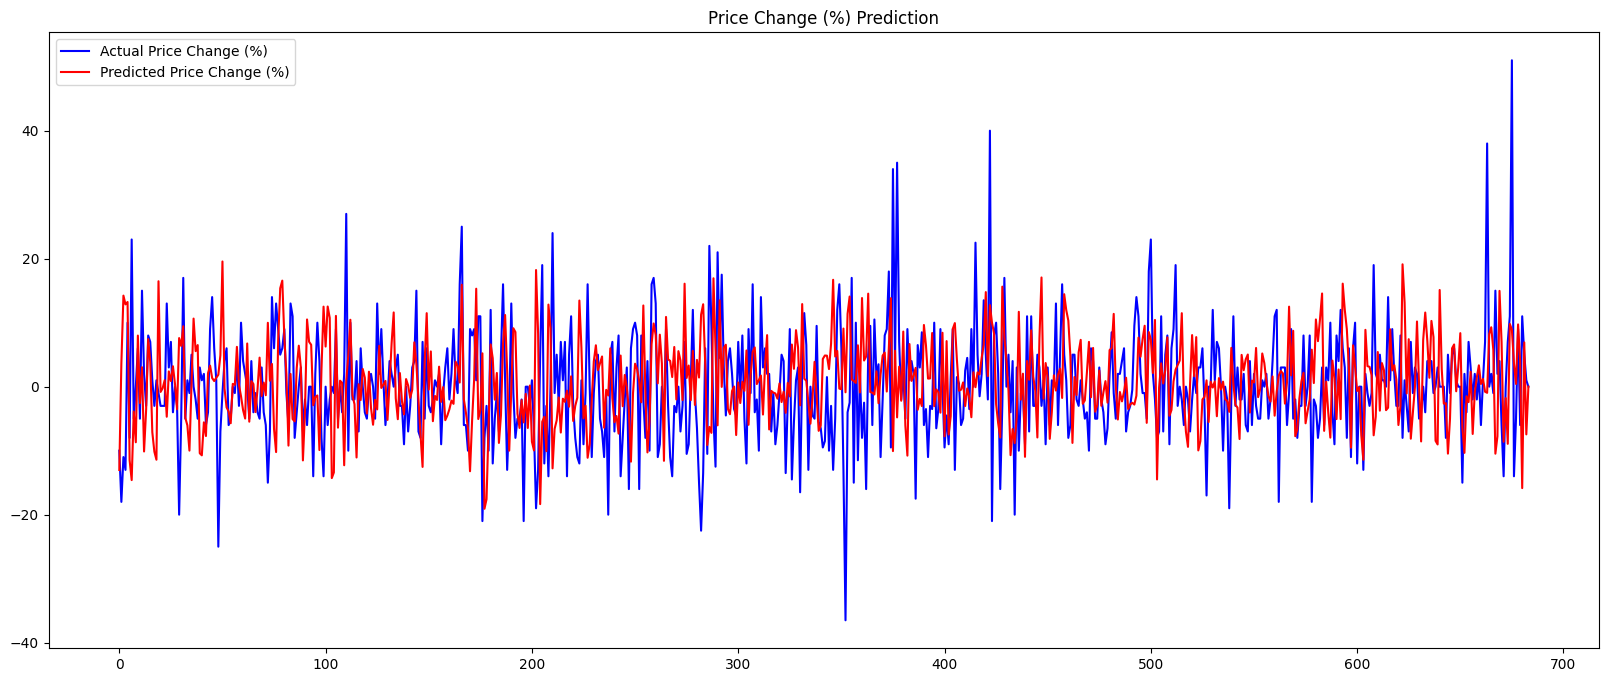

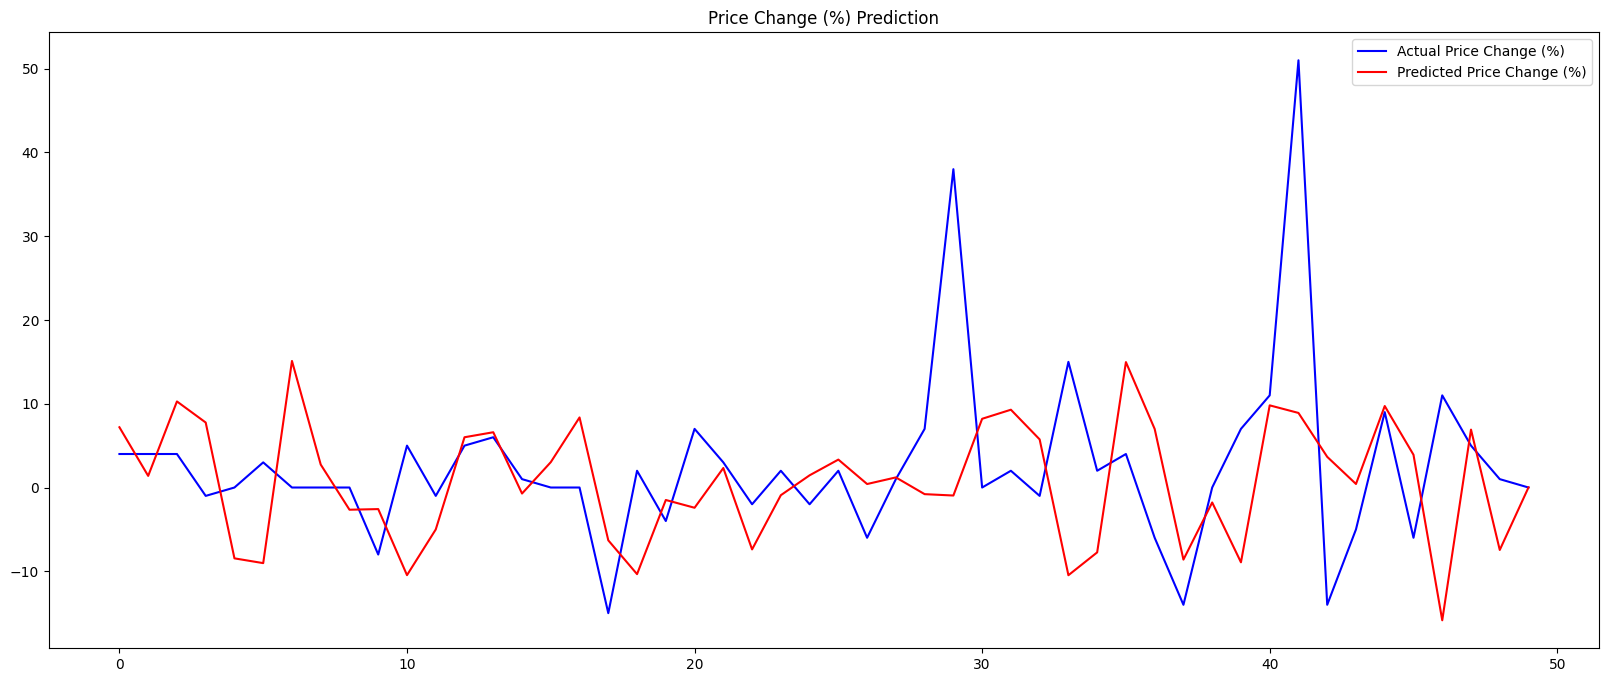

第3次 建立模型
| epoch  10 | lr 0.0100000000 | 127.25 ms | loss 74.8505594
| epoch  20 | lr 0.0095000000 | 119.00 ms | loss 74.5091098
| epoch  30 | lr 0.0090250000 | 124.77 ms | loss 74.4655642
| epoch  40 | lr 0.0085737500 | 94.74 ms | loss 74.5476797
| epoch  50 | lr 0.0081450625 | 94.77 ms | loss 74.3532666
| epoch  60 | lr 0.0077378094 | 96.64 ms | loss 74.6574530
| epoch  70 | lr 0.0073509189 | 91.88 ms | loss 74.5081057
| epoch  80 | lr 0.0069833730 | 93.43 ms | loss 74.4549268
| epoch  90 | lr 0.0066342043 | 91.97 ms | loss 74.3809440
| epoch 100 | lr 0.0063024941 | 93.12 ms | loss 74.2573786
| epoch 110 | lr 0.0059873694 | 100.15 ms | loss 74.0571269
| epoch 120 | lr 0.0056880009 | 93.35 ms | loss 73.8497403
| epoch 130 | lr 0.0054036009 | 94.70 ms | loss 73.5779129
| epoch 140 | lr 0.0051334208 | 92.22 ms | loss 75.0250567
| epoch 150 | lr 0.0048767498 | 141.86 ms | loss 71.9479961
| epoch 160 | lr 0.0046329123 | 120.04 ms | loss 74.5118248
| epoch 170 | lr 0.0044012667 | 138.27 ms

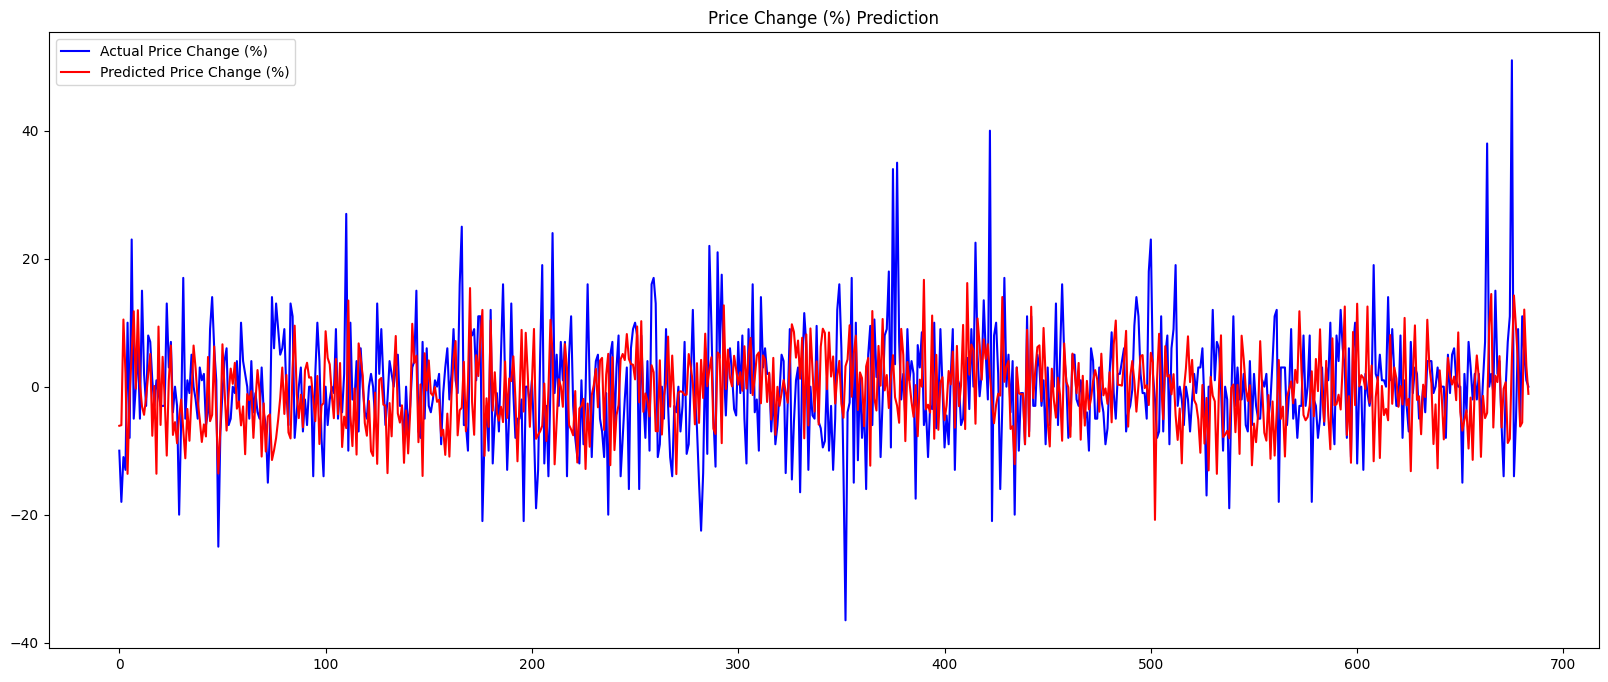

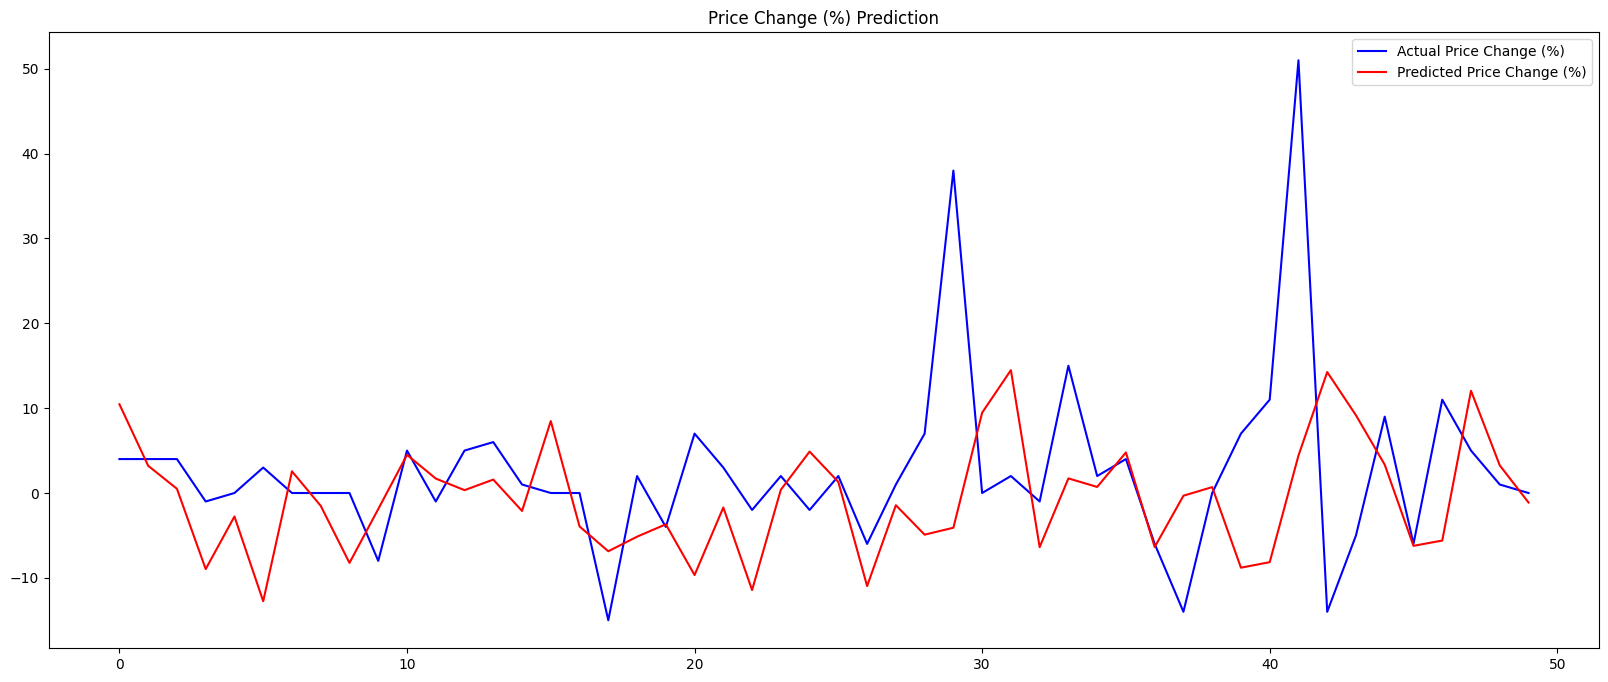

第4次 建立模型
| epoch  10 | lr 0.0100000000 | 102.30 ms | loss 74.8334774
| epoch  20 | lr 0.0095000000 | 94.88 ms | loss 74.5375182
| epoch  30 | lr 0.0090250000 | 118.64 ms | loss 74.5028538
| epoch  40 | lr 0.0085737500 | 120.87 ms | loss 74.5202624
| epoch  50 | lr 0.0081450625 | 125.06 ms | loss 74.4917309
| epoch  60 | lr 0.0077378094 | 94.75 ms | loss 74.5113365
| epoch  70 | lr 0.0073509189 | 99.66 ms | loss 74.5478409
| epoch  80 | lr 0.0069833730 | 95.77 ms | loss 74.4300540
| epoch  90 | lr 0.0066342043 | 91.29 ms | loss 74.4714735
| epoch 100 | lr 0.0063024941 | 91.99 ms | loss 74.2094646
| epoch 110 | lr 0.0059873694 | 93.26 ms | loss 74.8169493
| epoch 120 | lr 0.0056880009 | 90.78 ms | loss 74.7324052
| epoch 130 | lr 0.0054036009 | 93.11 ms | loss 74.7052124
| epoch 140 | lr 0.0051334208 | 93.44 ms | loss 74.6889046
| epoch 150 | lr 0.0048767498 | 95.15 ms | loss 74.4565274
| epoch 160 | lr 0.0046329123 | 134.61 ms | loss 74.3432539
| epoch 170 | lr 0.0044012667 | 121.44 ms 

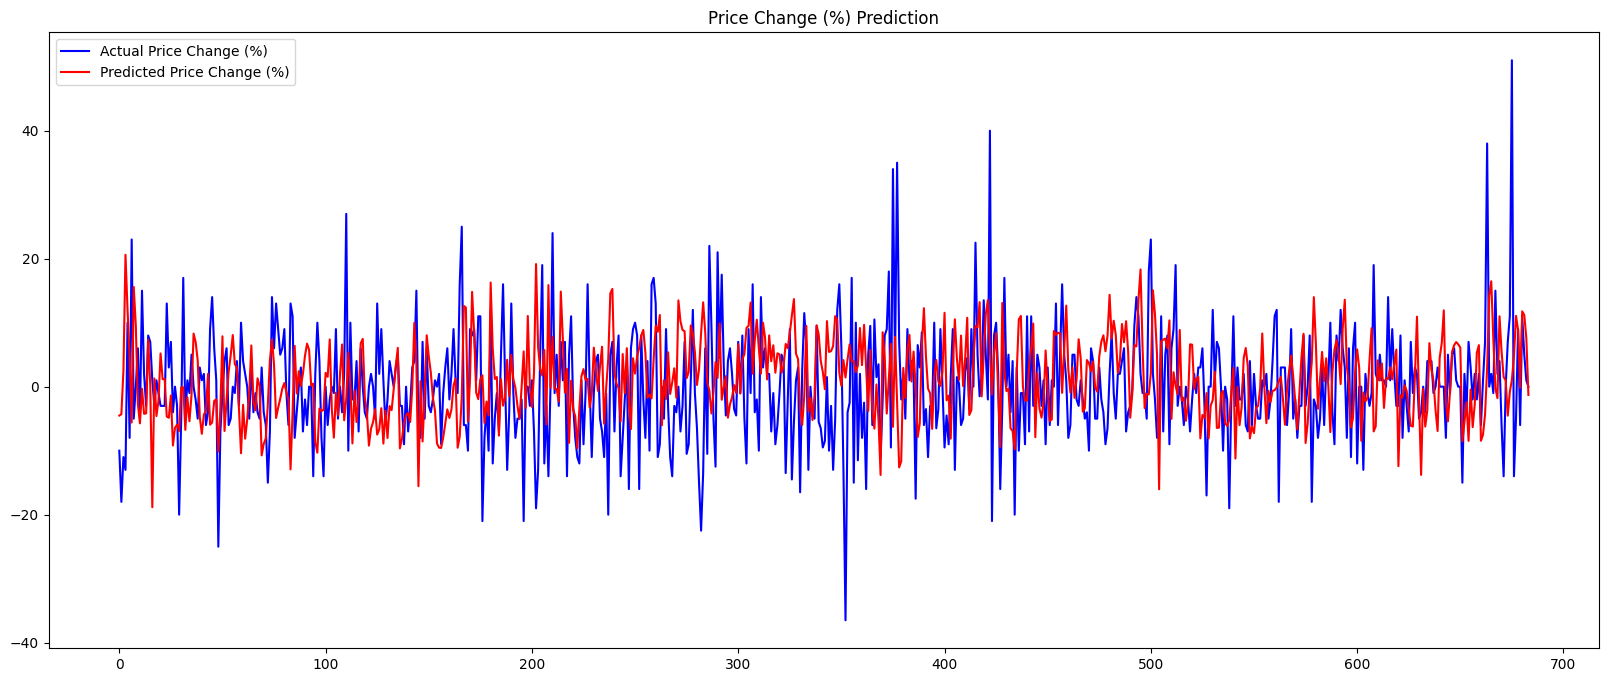

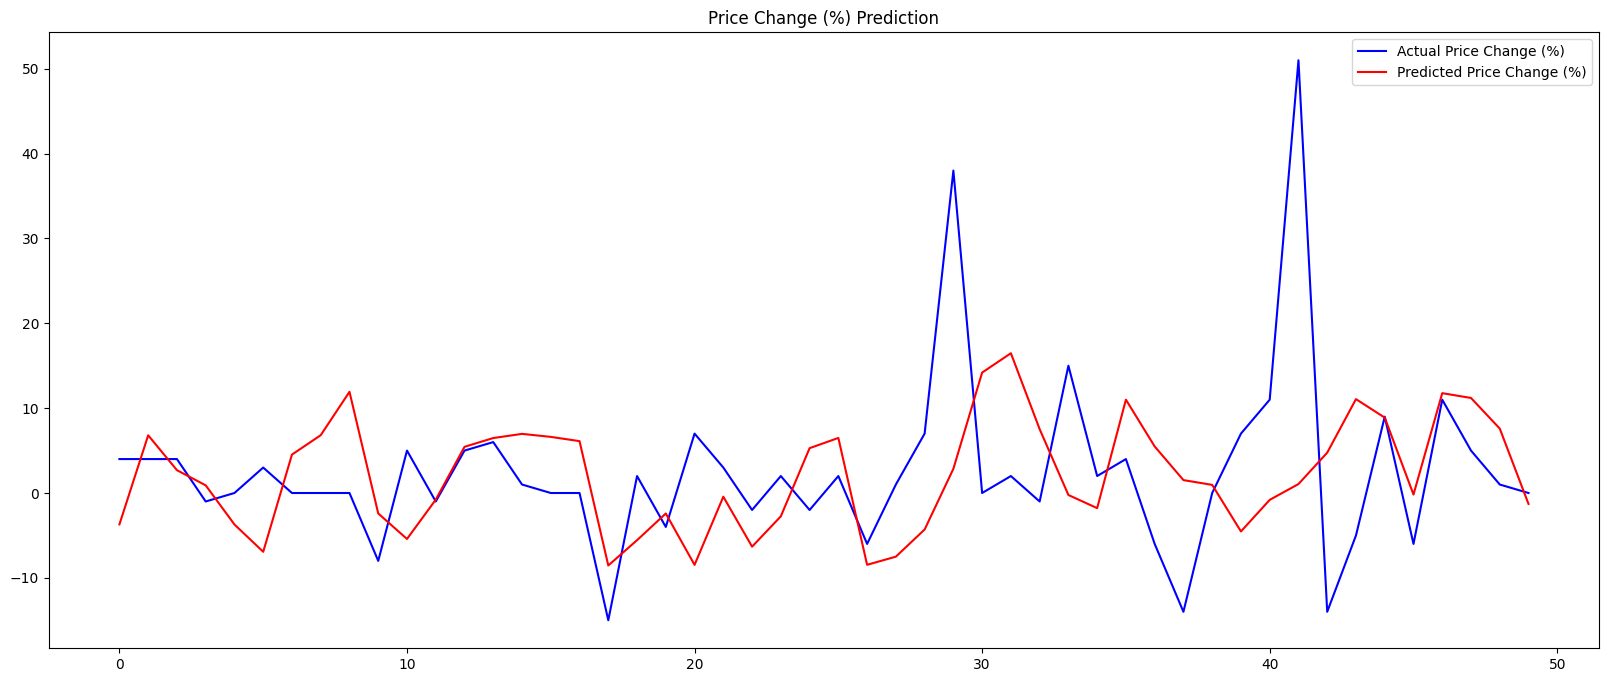

第7次 建立模型
| epoch  10 | lr 0.0100000000 | 101.33 ms | loss 74.7941158
| epoch  20 | lr 0.0095000000 | 91.46 ms | loss 74.5574310
| epoch  30 | lr 0.0090250000 | 94.24 ms | loss 74.5280764
| epoch  40 | lr 0.0085737500 | 125.18 ms | loss 74.5039253
| epoch  50 | lr 0.0081450625 | 134.80 ms | loss 74.4867784
| epoch  60 | lr 0.0077378094 | 137.57 ms | loss 74.4820896
| epoch  70 | lr 0.0073509189 | 104.24 ms | loss 74.4070857
| epoch  80 | lr 0.0069833730 | 96.07 ms | loss 74.6056468
| epoch  90 | lr 0.0066342043 | 97.57 ms | loss 74.5931483
| epoch 100 | lr 0.0063024941 | 94.22 ms | loss 74.6027398
| epoch 110 | lr 0.0059873694 | 93.08 ms | loss 74.6025878
| epoch 120 | lr 0.0056880009 | 93.95 ms | loss 74.6035011
| epoch 130 | lr 0.0054036009 | 93.80 ms | loss 74.5998501
| epoch 140 | lr 0.0051334208 | 93.42 ms | loss 74.5989378
| epoch 150 | lr 0.0048767498 | 99.04 ms | loss 74.5978547
| epoch 160 | lr 0.0046329123 | 94.84 ms | loss 74.5974650
| epoch 170 | lr 0.0044012667 | 112.79 ms 

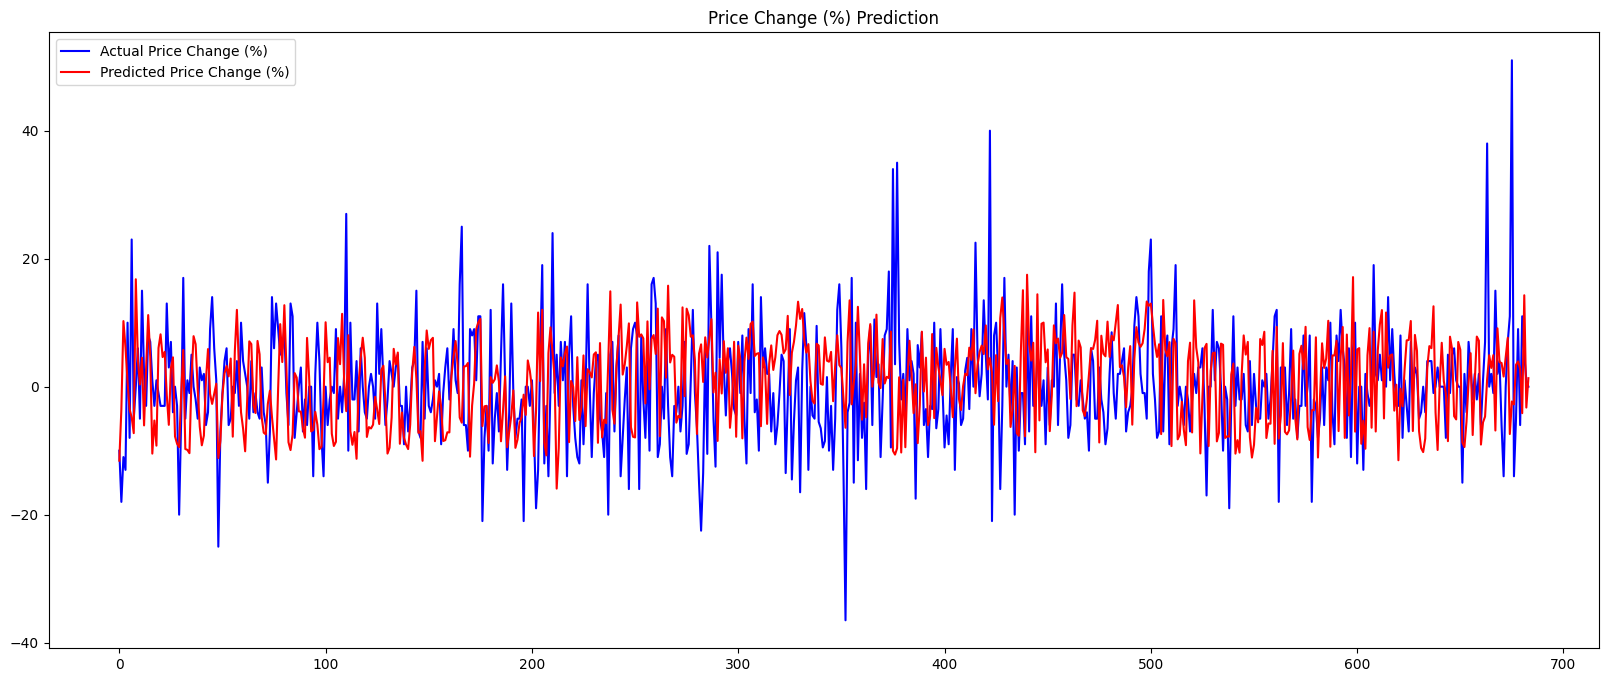

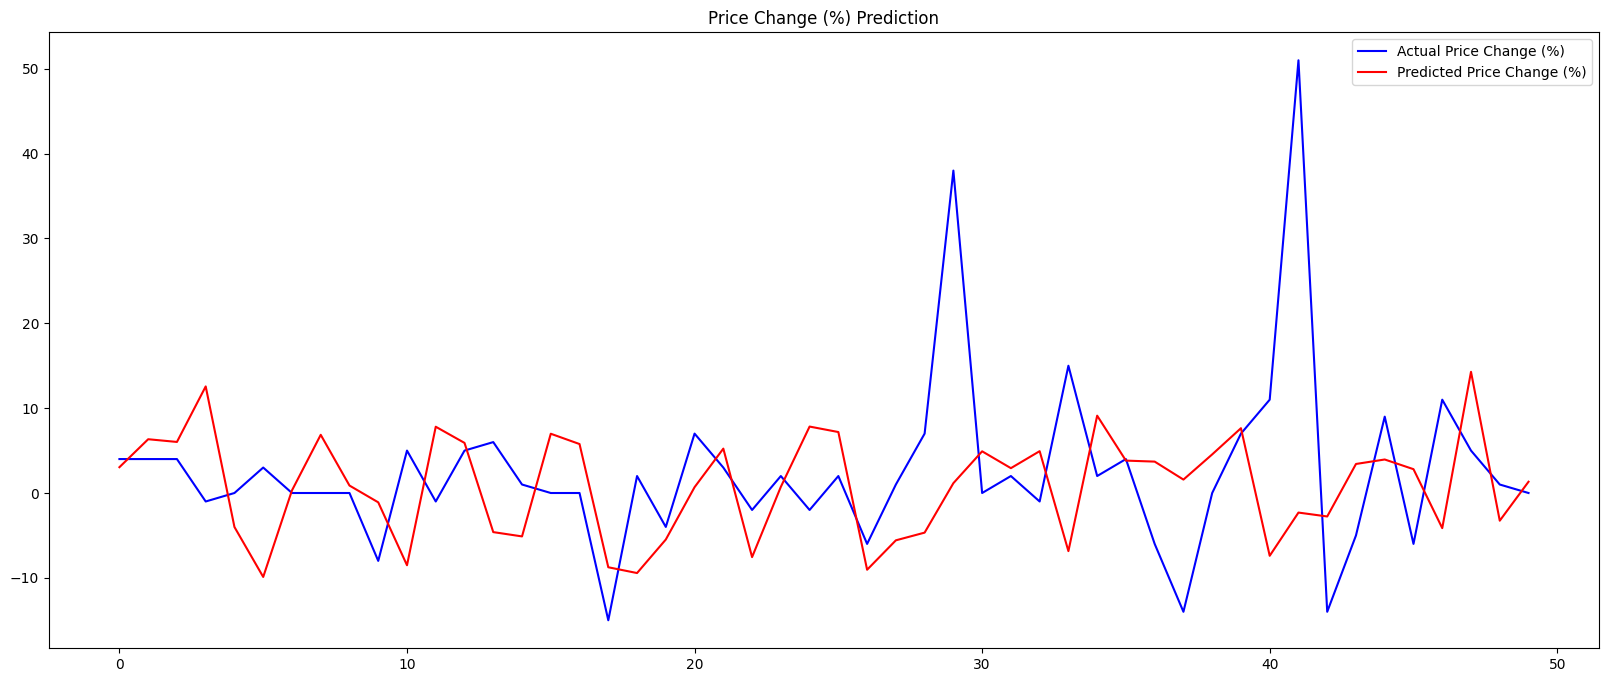

第8次 建立模型
| epoch  10 | lr 0.0100000000 | 107.57 ms | loss 74.8359797
| epoch  20 | lr 0.0095000000 | 93.69 ms | loss 74.5355121
| epoch  30 | lr 0.0090250000 | 90.96 ms | loss 74.5087824
| epoch  40 | lr 0.0085737500 | 93.56 ms | loss 74.5149014
| epoch  50 | lr 0.0081450625 | 93.71 ms | loss 74.5159529
| epoch  60 | lr 0.0077378094 | 120.59 ms | loss 74.5713008
| epoch  70 | lr 0.0073509189 | 112.03 ms | loss 74.5298464
| epoch  80 | lr 0.0069833730 | 131.46 ms | loss 74.5070355
| epoch  90 | lr 0.0066342043 | 99.39 ms | loss 74.4798079
| epoch 100 | lr 0.0063024941 | 96.00 ms | loss 74.4177252
| epoch 110 | lr 0.0059873694 | 96.97 ms | loss 74.6120241
| epoch 120 | lr 0.0056880009 | 95.87 ms | loss 74.6058788
| epoch 130 | lr 0.0054036009 | 100.84 ms | loss 74.6225369
| epoch 140 | lr 0.0051334208 | 92.67 ms | loss 74.5146814
| epoch 150 | lr 0.0048767498 | 91.09 ms | loss 74.4427096
| epoch 160 | lr 0.0046329123 | 91.30 ms | loss 74.5882594
| epoch 170 | lr 0.0044012667 | 94.58 ms |

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import time
import matplotlib.pyplot as plt
import datetime

# 取當前時間
current_time = datetime.datetime.now()

# 格式化
formatted_time = current_time.strftime("%Y_%m_%d_%H_%M_%S")

print("當前時間:", formatted_time)

# 讀取數據
data = pd.read_csv('/content/drive/MyDrive/LSTM/input/stock_train/2330_2000_to_202402.csv')

# 選擇需要的特徵和目標變量
features = data[['Open', 'High', 'Low', 'Close', 'Volume']]
target = data['Change']

# 將日期轉換為數字（如果需要）
data['Date'] = pd.to_datetime(data['Date'])
data['Date'] = data['Date'].map(pd.Timestamp.timestamp)

# 標準化數據
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# 將數據拆分為訓練集和測試集，80%訓練，20%測試
train_size = int(len(scaled_features) * 0.8)
test_size = len(scaled_features) - train_size

train_features = scaled_features[:train_size]
train_target = target[:train_size]
test_features = scaled_features[train_size:]
test_target = target[train_size:]

# 創建LSTM的輸入格式
def create_sequences(features, target, time_step=1):
    X, y = [], []
    for i in range(len(features) - time_step - 1):
        X.append(features[i:(i + time_step), :])
        y.append(target[i + time_step])
    return np.array(X), np.array(y)
# LSTM的時間步長
time_step = 10
# 建立訓練資料與測試資料
X_train, y_train = create_sequences(train_features, train_target.values, time_step)
X_test, y_test = create_sequences(test_features, test_target.values, time_step)

# 檢查CUDA是否可用
USE_CUDA = torch.cuda.is_available()
# 設定GPU可用則使用cuda:0，不可用則用CPU
device = torch.device('cuda:0' if USE_CUDA else 'cpu')
print("****CUDA狀態****")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CUDA Device: {torch.cuda.current_device()}")
print(f"CUDA Device Name: {torch.cuda.get_device_name(device)}")

# 將訓練集特徵數據轉換為 PyTorch 張量，並指定數據類型為 float32，然後將其移動到指定設備（GPU 或 CPU）
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
# 將訓練集目標數據轉換為 PyTorch 張量，並指定數據類型為 float32，同時調整形狀為（-1, 1）（將其轉換為列向量），然後將其移動到指定設備（GPU 或 CPU）
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
# 將測試集特徵數據轉換為 PyTorch 張量，並指定數據類型為 float32，然後將其移動到指定設備（GPU 或 CPU）
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
# 將測試集目標數據轉換為 PyTorch 張量，並指定數據類型為 float32，同時調整形狀為（-1, 1）（將其轉換為列向量），然後將其移動到指定設備（GPU 或 CPU）
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)
print("****數據狀態****")
print(f"訓練資料:{len(X_train_tensor)}筆")
print(f"測試資料:{len(X_test_tensor)}筆")
# 定義一個名為 LSTM 的類，繼承自 nn.Module
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        # 調用父類 nn.Module 的構造函數
        super(LSTM, self).__init__()
        # 設定 LSTM 模型的隱藏層維度
        self.hidden_dim = hidden_dim
        # 設定 LSTM 模型的層數
        self.num_layers = num_layers
        # 創建 LSTM 層，指定輸入維度、隱藏層維度、層數和批次優先的設置
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        # 創建全連接層，將隱藏層的輸出映射到輸出維度
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # 初始化 LSTM 的隱藏狀態和細胞狀態，設置為全零，並移動到指定設備
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        # 將輸入數據移動到指定設備，並傳遞給 LSTM 層，得到輸出和新的隱藏狀態、細胞狀態
        out, (hn, cn) = self.lstm(x.to(device), (h0.detach(), c0.detach()))
        # 將 LSTM 的輸出傳遞給全連接層，僅使用最後一個時間步的輸出
        out = self.fc(out[:, -1, :])
        # 將最終輸出移動到指定設備並返回
        return out.to(device)

# 設定超參數
# 獲取輸入數據的維度
input_dim = X_train.shape[2]
# 設定 LSTM 模型的隱藏層維度
hidden_dim = 100
# 設定 LSTM 模型的層數
num_layers = 2
# 設定模型的輸出維度
output_dim = 1
# 設定LSTM堆疊的dropout層
dropout = 0

# 初始化學習率
initial_lr = 0.01
# 設置批次大小
batch_size = 64
# 根據新的批次大小與原批次大小的比例來計算縮放因子
scale_factor = batch_size / 64 # 原批次大小為 64
# 調整學習率，使其與新的批次大小成比例增長
lr = initial_lr * scale_factor
# 定義損失函數和優化器
criterion = nn.SmoothL1Loss()
# 希望有多少數據%達標25%停止
pr=0.25
# 紀錄創建模型次數
training_times = 0
total_loss = 0
model_save = 0
while(True):
    training_times = training_times + 1
    print(f"第{training_times}次 建立模型")
    # 創建 LSTM 模型並將其移動到GPU上
    model = LSTM(input_dim, hidden_dim, num_layers, output_dim, dropout).to(device)
    # 設置訓練的總epoch數
    num_epochs = 1000
    # 設置最佳驗證集上的損失初始值為無窮大
    best_valid_loss = float('inf')
    # 設置提前停止訓練的閾值
    early_stop_threshold = 1000
    # 初始化連續未改善的epoch計數器
    no_improvement_count = 0
    # 優化器設定
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    # 定義學習率調度器，每十個epoch將學習率減小為原來的0.95
    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)
    # 記錄訓練開始時間
    train_start = time.time()
    # 訓練 LSTM 模型
    for epoch in range(num_epochs):
        model.train()  # 將模型設置為訓練模式
        start_time = time.time()  # 記錄當前epoch的開始時間
        total_loss = 0
        for i in range(0, len(X_train_tensor), batch_size):
            batch_X = X_train_tensor[i:i+batch_size]  # 從訓練集中取出一個批次的特徵數據
            batch_y = y_train_tensor[i:i+batch_size]  # 從訓練集中取出一個批次的目標數據
            # 獲取模型的預測結果
            outputs = model(batch_X)
            # 計算模型的損失
            loss = criterion(outputs, batch_y)
            # 梯度反向傳播和參數更新
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss = total_loss + loss.item()
        if(epoch >= 850 and total_loss >= 50.0):
            print(f"因LOSS過高提早結束，{epoch+1}epoch")
            break
        if(epoch>=int(num_epochs/2)):
            # 在每個epoch後評估模型在驗證集上的性能
            model.eval()  # 將模型設置為評估模式
            valid_loss = 0
            with torch.no_grad():
                for i in range(0, len(X_test_tensor), batch_size):
                    batch_X_valid = X_test_tensor[i:i+batch_size]
                    batch_y_valid = y_test_tensor[i:i+batch_size]
                    valid_outputs = model(batch_X_valid)
                    valid_loss += criterion(valid_outputs, batch_y_valid).item()
            valid_loss /= len(X_test_tensor) / batch_size

            # 如果驗證集上的損失比最佳損失還小，更新最佳損失並重置未改善epoch的計數器
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            # 如果連續未改善epoch的計數器達到提前停止訓練的閾值，則停止訓練
            if no_improvement_count >= early_stop_threshold:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
        scheduler.step()  # 每個epoch結束後調整學習率(記數)
        if epoch % 10 == 0:
            elapsed = time.time() - start_time  # 計算當前epoch的執行時間
            # 打印訓練過程中的一些信息，如當前epoch數、學習率、執行時間和損失
            print('| epoch {:3d} | lr {:02.10f} | {:5.2f} ms | loss {:5.7f}'.format(
                epoch+10,scheduler.get_last_lr()[0], elapsed * 1000, total_loss))
    train_times = time.time() - train_start  # 計算整個訓練過程的總執行時間
    print(f"training cost:{train_times}s")  # 打印整個訓練過程的執行時間

    # 將模型設置為評估模式，關閉了訓練中的一些特定操作，如Dropout和Batch Normalization中的隨機失活
    model.eval()
    # 使用測試集數據進行預測
    test_outputs = model(X_test_tensor)  # 獲取模型對測試集特徵數據的預測結果
    # 計算測試集的損失
    test_loss = criterion(test_outputs, y_test_tensor)  # 使用預測結果和測試集目標數據計算損失
    # 打印測試集的損失
    print(f'Test Loss: {test_loss.item()}')  # 將測試集損失轉換為Python數值並打印出來
    # 獲取預測值和實際值
    predicted = test_outputs.detach().cpu().numpy()
    actual = y_test_tensor.cpu().reshape(-1, 1).numpy()

    # 上調 predicted 和 actual，使其不會小於等於 0，並且上限為 100
    predicted = np.clip(predicted, 1, 100)
    actual = np.clip(actual, 1, 100)

    # 計算預測值與實際值之間的相對差異
    diff_percentage = np.divide(np.abs(predicted - actual), actual)

    # 設置閥值為25%
    threshold = 0.25

    # 計算有多少百分比的預測值與實際值之間的相對差異小於閥值
    within_threshold = np.sum(diff_percentage < threshold) / len(actual)


    # 如果有50%以上的預測值與實際值之間的差異小於25%，打印“成功”
    if (within_threshold >= pr and total_loss < 50):
        print(f"預測與真實數據差異在25%內有: {within_threshold*100}% 的數據\n目標: {pr*100}% 有成功！！！")
        # 保存模型
        model_save = model_save + 1
        torch.save(model.state_dict(), f"/content/drive/MyDrive/LSTM/model/LSTM_{formatted_time}_{model_save}")
        # 獲取預測值和實際值
        predicted = test_outputs.detach().cpu().numpy()
        actual = y_test_tensor.cpu().reshape(-1, 1)

        # 繪製預測結果與實際值的折線圖
        plt.figure(figsize=(20,8))  # 設置圖片大小
        plt.plot(actual, color='blue', label='Actual Price Change (%)')  # 繪製實際值的折線圖，顏色為藍色
        plt.plot(predicted, color='red', label='Predicted Price Change (%)')  # 繪製預測值的折線圖，顏色為紅色
        plt.title('Price Change (%) Prediction')  # 設置圖表標題
        plt.legend()  # 添加圖例
        plt.show()  # 顯示圖表

        # 從模型的預測結果中獲取最後50筆資料，並轉換為NumPy陣列
        predicted = test_outputs[-50:].detach().cpu().numpy()

        # 從測試集的實際值中獲取最後50筆資料，並轉換為NumPy陣列
        actual = y_test_tensor[-50:].cpu().numpy()

        # 繪製預測結果與實際值的折線圖
        plt.figure(figsize=(20,8))  # 設置圖片大小
        plt.plot(actual, color='blue', label='Actual Price Change (%)')  # 繪製實際值的折線圖，顏色為藍色
        plt.plot(predicted, color='red', label='Predicted Price Change (%)')  # 繪製預測值的折線圖，顏色為紅色
        plt.title('Price Change (%) Prediction')  # 設置圖表標題
        plt.legend()  # 添加圖例
        plt.show()  # 顯示圖表
        if(training_times>=100):
          break
    else:
        if total_loss >= 50 :
          print(f"因LOSS過高提早結束，不保存")
        else :
          print(f"預測與真實數據差異在25%內有: {within_threshold*100}% 的數據\n目標: {pr*100}% 失敗了～")
        if(training_times>=100):
          break
        continue

# 回歸任務

當前時間: 2024_06_09_16_14_33
****CUDA狀態****
CUDA Available: True
CUDA Device: 0
CUDA Device Name: Tesla T4
****數據狀態****
訓練資料:2768筆
測試資料:684筆
Test Loss: 8.774524688720703
預測與真實數據差異在25%內有: 30.84795321637427% 的數據
目標: 30.0% 有成功！！！


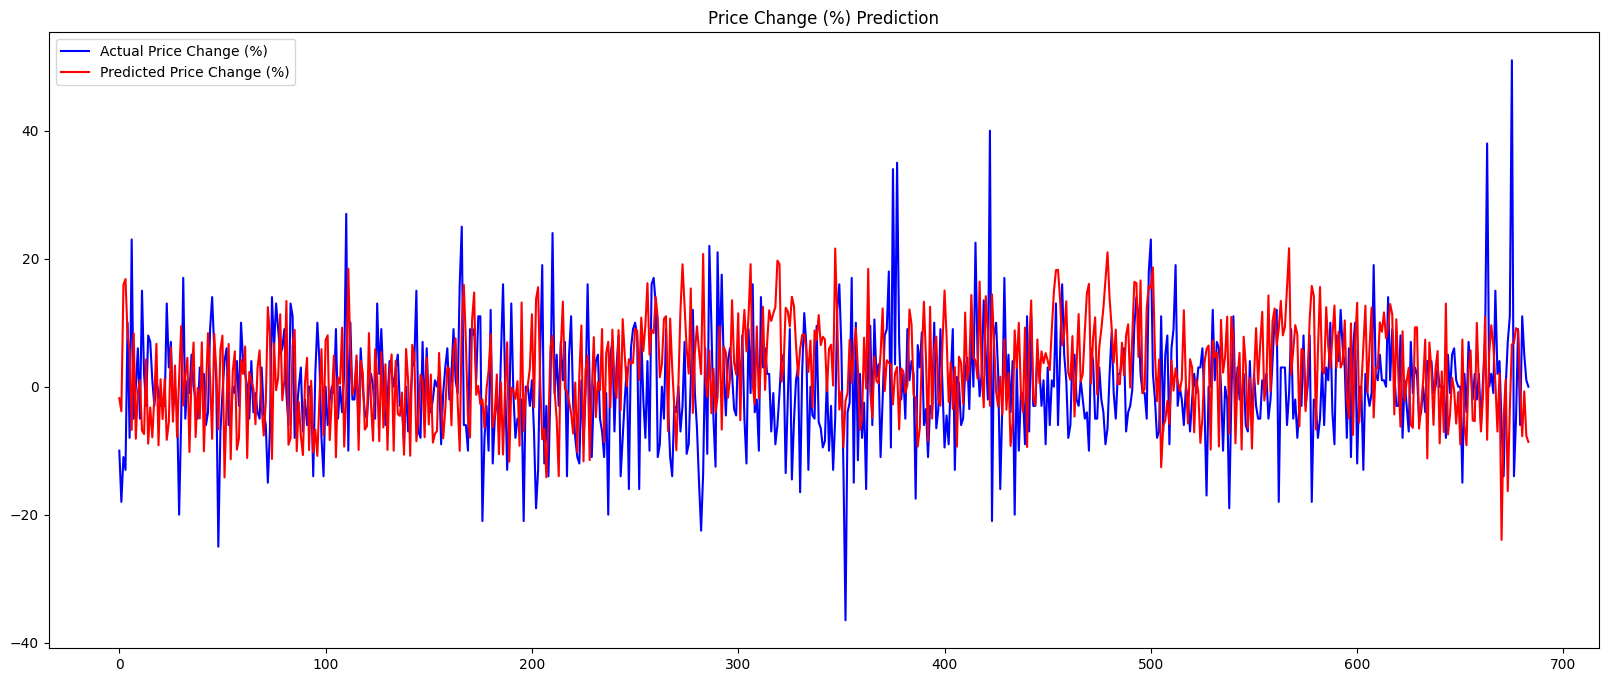

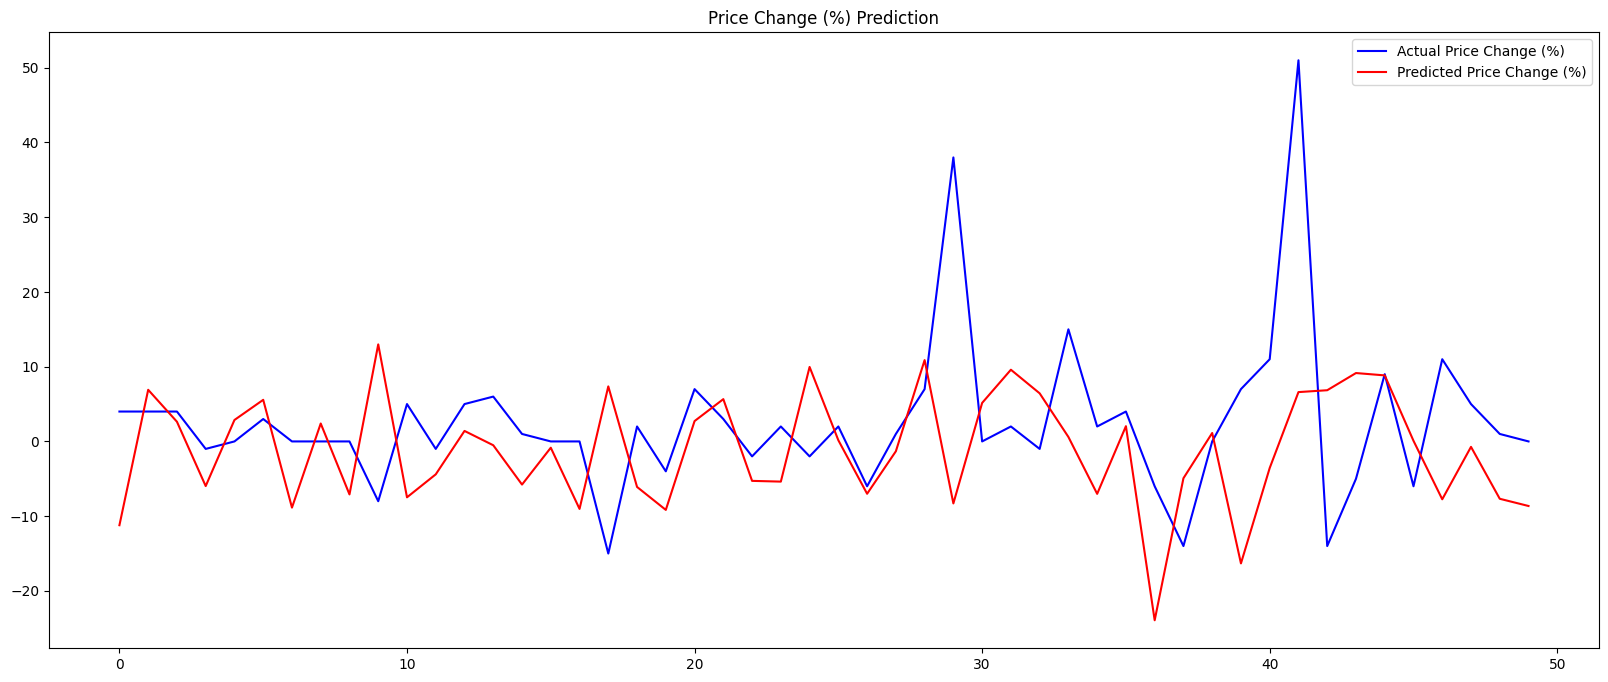

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import time
import matplotlib.pyplot as plt
import datetime

# 取當前時間
current_time = datetime.datetime.now()

# 格式化
formatted_time = current_time.strftime("%Y_%m_%d_%H_%M_%S")

print("當前時間:", formatted_time)

# 讀取數據
data = pd.read_csv('/content/drive/MyDrive/LSTM/input/stock_train/2330_2000_to_202402.csv')

# 選擇需要的特徵和目標變量
features = data[['Open', 'High', 'Low', 'Close', 'Volume']]
target = data['Change']

# 將日期轉換為數字（如果需要）
data['Date'] = pd.to_datetime(data['Date'])
data['Date'] = data['Date'].map(pd.Timestamp.timestamp)

# 標準化數據
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# 將數據拆分為訓練集和測試集，80%訓練，20%測試
train_size = int(len(scaled_features) * 0.8)
test_size = len(scaled_features) - train_size

train_features = scaled_features[:train_size]
train_target = target[:train_size]
test_features = scaled_features[train_size:]
test_target = target[train_size:]

# 創建LSTM的輸入格式
def create_sequences(features, target, time_step=1):
    X, y = [], []
    for i in range(len(features) - time_step - 1):
        X.append(features[i:(i + time_step), :])
        y.append(target[i + time_step])
    return np.array(X), np.array(y)
# LSTM的時間步長
time_step = 10
# 建立訓練資料與測試資料
X_train, y_train = create_sequences(train_features, train_target.values, time_step)
X_test, y_test = create_sequences(test_features, test_target.values, time_step)

# 檢查CUDA是否可用
USE_CUDA = torch.cuda.is_available()
# 設定GPU可用則使用cuda:0，不可用則用CPU
device = torch.device('cuda:0' if USE_CUDA else 'cpu')
print("****CUDA狀態****")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CUDA Device: {torch.cuda.current_device()}")
print(f"CUDA Device Name: {torch.cuda.get_device_name(device)}")

# 將訓練集特徵數據轉換為 PyTorch 張量，並指定數據類型為 float32，然後將其移動到指定設備（GPU 或 CPU）
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
# 將訓練集目標數據轉換為 PyTorch 張量，並指定數據類型為 float32，同時調整形狀為（-1, 1）（將其轉換為列向量），然後將其移動到指定設備（GPU 或 CPU）
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
# 將測試集特徵數據轉換為 PyTorch 張量，並指定數據類型為 float32，然後將其移動到指定設備（GPU 或 CPU）
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
# 將測試集目標數據轉換為 PyTorch 張量，並指定數據類型為 float32，同時調整形狀為（-1, 1）（將其轉換為列向量），然後將其移動到指定設備（GPU 或 CPU）
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)
print("****數據狀態****")
print(f"訓練資料:{len(X_train_tensor)}筆")
print(f"測試資料:{len(X_test_tensor)}筆")
# 定義一個名為 LSTM 的類，繼承自 nn.Module
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout):
        # 調用父類 nn.Module 的構造函數
        super(LSTM, self).__init__()
        # 設定 LSTM 模型的隱藏層維度
        self.hidden_dim = hidden_dim
        # 設定 LSTM 模型的層數
        self.num_layers = num_layers
        # 創建 LSTM 層，指定輸入維度、隱藏層維度、層數和批次優先的設置
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        # 創建全連接層，將隱藏層的輸出映射到輸出維度
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # 初始化 LSTM 的隱藏狀態和細胞狀態，設置為全零，並移動到指定設備
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        # 將輸入數據移動到指定設備，並傳遞給 LSTM 層，得到輸出和新的隱藏狀態、細胞狀態
        out, (hn, cn) = self.lstm(x.to(device), (h0.detach(), c0.detach()))
        # 將 LSTM 的輸出傳遞給全連接層，僅使用最後一個時間步的輸出
        out = self.fc(out[:, -1, :])
        # 將最終輸出移動到指定設備並返回
        return out.to(device)

# 設定超參數
# 獲取輸入數據的維度
input_dim = X_train.shape[2]
# 設定 LSTM 模型的隱藏層維度
hidden_dim = 50
# 設定 LSTM 模型的層數
num_layers = 2
# 設定模型的輸出維度
output_dim = 1
# 設定LSTM堆疊的dropout層
dropout = 0

# 初始化學習率
initial_lr = 0.01
# 設置批次大小
batch_size = 64
# 根據新的批次大小與原批次大小的比例來計算縮放因子
scale_factor = batch_size / 64 # 原批次大小為 64
# 調整學習率，使其與新的批次大小成比例增長
lr = initial_lr * scale_factor
# 定義損失函數和優化器
criterion = nn.SmoothL1Loss()
# 希望有多少數據%達標25%停止
pr=0.3
# 紀錄創建模型次數
training_times = 0
total_loss = 0


# 加載模型
model = LSTM(input_dim, hidden_dim, num_layers, output_dim, dropout).to(device)
model.load_state_dict(torch.load('/content/LSTM_2024_06_09_15_52_35_3.pth'))

# 將模型設置為評估模式，關閉了訓練中的一些特定操作，如Dropout和Batch Normalization中的隨機失活
model.eval()
# 使用測試集數據進行預測
test_outputs = model(X_test_tensor)  # 獲取模型對測試集特徵數據的預測結果
# 計算測試集的損失
test_loss = criterion(test_outputs, y_test_tensor)  # 使用預測結果和測試集目標數據計算損失
# 打印測試集的損失
print(f'Test Loss: {test_loss.item()}')  # 將測試集損失轉換為Python數值並打印出來


# 獲取預測值和實際值
predicted = test_outputs.detach().cpu().numpy()
actual = y_test_tensor.cpu().reshape(-1, 1).numpy()

# 上調 predicted 和 actual，使其不會小於等於 0，並且上限為 100
predicted = np.clip(predicted, 1, 100)
actual = np.clip(actual, 1, 100)

# 計算預測值與實際值之間的相對差異
diff_percentage = np.divide(np.abs(predicted - actual), actual)

# 設置閥值為25%
threshold = 0.25

# 計算有多少百分比的預測值與實際值之間的相對差異小於閥值
within_threshold = np.sum(diff_percentage < threshold) / len(actual)


# 如果有50%以上的預測值與實際值之間的差異小於25%，打印“成功”
if (within_threshold >= pr and total_loss < 30):
    print(f"預測與真實數據差異在25%內有: {within_threshold*100}% 的數據\n目標: {pr*100}% 有成功！！！")
else:
    print(f"預測與真實數據差異在25%內有: {within_threshold*100}% 的數據\n目標: {pr*100}% 失敗了～")

# 獲取預測值和實際值
predicted = test_outputs.detach().cpu().numpy()
actual = y_test_tensor.cpu().reshape(-1, 1)

# 繪製預測結果與實際值的折線圖
plt.figure(figsize=(20,8))  # 設置圖片大小
plt.plot(actual, color='blue', label='Actual Price Change (%)')  # 繪製實際值的折線圖，顏色為藍色
plt.plot(predicted, color='red', label='Predicted Price Change (%)')  # 繪製預測值的折線圖，顏色為紅色
plt.title('Price Change (%) Prediction')  # 設置圖表標題
plt.legend()  # 添加圖例
plt.show()  # 顯示圖表

# 從模型的預測結果中獲取最後50筆資料，並轉換為NumPy陣列
predicted = test_outputs[-50:].detach().cpu().numpy()

# 從測試集的實際值中獲取最後50筆資料，並轉換為NumPy陣列
actual = y_test_tensor[-50:].cpu().numpy()

# 繪製預測結果與實際值的折線圖
plt.figure(figsize=(20,8))  # 設置圖片大小
plt.plot(actual, color='blue', label='Actual Price Change (%)')  # 繪製實際值的折線圖，顏色為藍色
plt.plot(predicted, color='red', label='Predicted Price Change (%)')  # 繪製預測值的折線圖，顏色為紅色
plt.title('Price Change (%) Prediction')  # 設置圖表標題
plt.legend()  # 添加圖例
plt.show()  # 顯示圖表